# ¿Cómo construyo un modelo de predicción para los impagos de préstamos de Lending Club?

## Introducción

**Contexto de Negocio** Hemos visto en el caso anterior lo que podemos hacer para determinar si un aspecto de la información personal (por ejemplo, si la información sobre los ingresos está verificada) es importante a la hora de predecir el estado de impago. Este tipo de análisis ayuda sin duda a simplificar el proceso de préstamo. Sin embargo, la pregunta más importante para toda empresa de préstamos es si un usuario incurrirá en impago o no.

**Problema** Construir un modelo de clasificación para determinar si un usuario incumplirá su préstamo o no.

**Contexto analítico** Como científico de datos, necesita perfeccionar el algoritmo de clasificación. Es importante verificar cuantitativamente que el algoritmo va a funcionar para los datos futuros. Además, es importante no depender únicamente de la regresión logística, ya que tiene algunas deficiencias que se manejan mejor con otros tipos de modelos. Consideraremos los modelos generados a partir de la regresión logística, así como dos nuevos algoritmos: los clasificadores Naive Bayes y los bosques aleatorios.

El caso está estructurado de la siguiente manera
1. generar un modelo de referencia a partir de la regresión logística
2. introducir los clasificadores Naive Bayes y los bosques aleatorios
3. utilizar estos algoritmos para actualizar nuestro modelo; y finalmente
4. utilizar la validación cruzada para seleccionar el mejor modelo

## Modelo de regresión logística

In [8]:
import pandas as pd
import pydotplus
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from io import StringIO
from IPython.display import Image, SVG
from graphviz import Source
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from scipy.stats import chi2_contingency, norm
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from statsmodels.formula.api import ols
from sympy import var, plot_implicit, Eq

# ignore log(0) and divide by 0 warning
np.seterr(divide='ignore');

In [9]:
df = pd.read_csv('data\Lending_club_cleaned_2.csv',
                 dtype = {'loan_status':'category', 'annual_inc':'float',
                          'verification_status':'category', 'emp_length':'category',
                          'home_ownership':'category', 'int_rate':'object',
                          'loan_amnt':'float', 'purpose':'category',
                          'term':'category', 'grade':'category'})
df['int_rate'] = df['int_rate'].str.rstrip('%').astype('float')

In [10]:
df.head()

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,10+ years,RENT,10.65,5000.0,credit_card,36 months,B
1,Charged Off,30000.0,Source Verified,< 1 year,RENT,15.27,2500.0,car,60 months,C
2,Fully Paid,12252.0,Not Verified,10+ years,RENT,15.96,2400.0,small_business,36 months,C
3,Fully Paid,49200.0,Source Verified,10+ years,RENT,13.49,10000.0,other,36 months,C
4,Fully Paid,80000.0,Source Verified,1 year,RENT,12.69,3000.0,other,60 months,B


Resultados y código del modelo final del caso anterior

In [14]:
# normalizar y configurar los datos
df_log = pd.concat([(df['loan_amnt'] - df['loan_amnt'].mean())/df['loan_amnt'].std(),
                     (df['int_rate'] - df['int_rate'].mean())/df['int_rate'].std(),
                     (df['annual_inc'] - df['annual_inc'].mean())/df['annual_inc'].std(),
                     pd.get_dummies(df['home_ownership'], prefix='home', drop_first=True),
                     pd.get_dummies(df['purpose'], prefix='purpose', drop_first=True),
                     pd.get_dummies(df['grade'], prefix='grade', drop_first=True)], axis=1)
df_log['verification_status'] = df['verification_status'].cat.codes
df_log['emp_length'] = df['emp_length'].cat.codes
df_log['term'] = df['term'].cat.codes
df_log['Intercept'] = 1

La serie `predict_withvs` contiene las probabilidades calculadas por nuestro modelo logístico. En este caso, los valores más cercanos a uno corresponden a los usuarios que tienen más probabilidades de pagar totalmente su deuda. Para visualizar esto un poco mejor, hemos creado un gráfico de dispersión de los usuarios teniendo en cuenta el importe del préstamo y los ingresos anuales. Cada punto está coloreado con la serie `predic_withvs`, donde los puntos más oscuros son los que se sitúan por debajo de un umbral determinado (y, por tanto, se clasifican como morosos). Utilizaremos la función de actualización a continuación para ver cómo se comporta nuestro clasificador con respecto al umbral dado. En un mundo perfecto, el mejor clasificador colorearía de amarillo los puntos de la izquierda y de azul los de la derecha:

## Árboles de decisión y bosques aleatorios

Vamos a hablar ahora del **clasificador de árbol de decisión**. La siguiente figura muestra un ejemplo. Los nodos de la parte inferior del árbol se llaman nodos hoja y todos los demás nodos se llaman nodos internos o nodos rama. Cada nodo contiene una cantidad específica de muestras que se indica con `samples=`. Entre estas muestras, la proporción de muestras que son morosas y no morosas se indica con `value=`. Los valores del resultado mayoritario se indican con `class=`.

Cuando se quiere predecir el estado de impago de un registro en particular, comience con el nodo más alto. Este nodo interno le indica la dirección que debe seguir en función del valor de `annual_inc`. Siguiendo las instrucciones de los nodos internos, se recorre el árbol hasta encontrar un nodo hoja. La etiqueta de resultado en ese nodo hoja es entonces el resultado predicho para el registro. Todo este proceso de predicción se parece mucho a lo que hacemos en nuestra vida diaria cuando tomamos una decisión (basándonos en la respuesta a una pregunta concreta, elegimos qué pregunta responder a continuación y, tras suficientes respuestas, llegamos a una conclusión).

![](tree-1.png)

### Ejercicio:

Suponga que tiene dos usuarios con "loan_amnt" igual a 10.000 y 100.000.000 respectivamente. ¿Cuáles son los estados predeterminados previstos para estos dos usuarios, utilizando el árbol de decisión anterior?

### ¿Cómo funciona el algoritmo?

Supongamos que queremos crear un árbol de decisión que prediga el "estado del préstamo" en función del "término" y el "estado de la verificación". Lo primero que debemos hacer es decidir qué nodo poner en la parte superior del árbol. Para ello, basta con determinar cuál de los dos es mejor para predecir el estado del préstamo. 

Por ejemplo, imaginemos que el nodo más alto del árbol es `term<0.5` (es decir, si el cliente pidió un préstamo con un plazo de `36 meses`). Idealmente, éste sería un clasificador perfecto si todos los clientes que pidieran un préstamo a "36 meses" pagaran totalmente su deuda y todos los clientes que no pidieran un préstamo a "36 meses" no pagaran. Está claro que no es así:

In [16]:
df_t=df_log.copy()
df_t['loan_status']=df['loan_status'].cat.codes

def get_ct(df, col):
    ct_res = pd.crosstab(col, df['loan_status'], margins=True)
    ct_res["Fully Paid(%)"] = ct_res[1]/ct_res["All"]
    return ct_res

get_ct(df_t,df_t['term']<0.5)

# Esta diciendo el porcentaje de cada lado de cada clase cae en inpago o pago 

loan_status,0,1,All,Fully Paid(%)
term,,,,
False,2367,8054,10421,0.772862
True,3073,25211,28284,0.891352
All,5440,33265,38705,0.859450


Entre todos los clientes que solicitaron un préstamo a 36 meses, el 89,1% no son morosos. Dado que no todos los clientes son morosos o no morosos, decimos que este conjunto es "impuro". Por ejemplo, el conjunto de clientes que solicitaron un préstamo a 60 meses también es impuro, ya que sólo el 77,2% de ellos no son morosos. Más que encontrar una regla perfecta que aísle un conjunto puro, el objetivo principal del algoritmo es seleccionar una regla que minimice la impureza global de los conjuntos resultantes.

Un método popular para medir la impureza de un conjunto es utilizar la llamada **impureza de Gini**:

$$
\begin{equation}
\begin{aligned}
\text{Gini}(\text{'term'}<0.5)=2(0.891)(1-0.891)\approx 0.193.\\
\text{Gini}(\text{'term'}\geq 0.5)=2(0.772)(1-0.772)\approx 0.351.\\
\end{aligned}
\end{equation}
$$ 

Entonces, la impureza global de la decisión `term`<0,5 se calcula como:

$$
\text{CART('term'<0.5)}=\frac{\text{Clients with term<0.5}}{\text{All clients}}\text{Gini}(\text{'term'}<0.5)+\frac{\text{Clients with term>0.5}}{\text{All clients}}\text{Gini}(\text{'term'}<0.5)\approx 0.23606
$$

Calculemos la impureza global de las decisiones `verified_source`<0,5 (es decir, clientes que son `Not Verified`) y `verified_source`<1,5 (es decir, clientes que son `Not Verified` o `Source Verified`):

In [13]:
ct=get_ct(df_t,df_t['verification_status']<0.5)
GiniTrue=2*ct.loc[True,'Fully Paid(%)']*(1-ct.loc[True,'Fully Paid(%)'])
GiniFalse=2*ct.loc[False,'Fully Paid(%)']*(1-ct.loc[False,'Fully Paid(%)'])
CART=(ct.loc[True,'All']*GiniTrue+ct.loc[False,'All']*GiniFalse)/ct.loc['All','All']
print('Overall inpurtity of `verification_status`<0.5 is ', CART)

NameError: name 'df_t' is not defined

In [ ]:
ct=get_ct(df_t,df_t['verification_status']<1.5)
GiniTrue=2*ct.loc[True,'Fully Paid(%)']*(1-ct.loc[True,'Fully Paid(%)'])
GiniFalse=2*ct.loc[False,'Fully Paid(%)']*(1-ct.loc[False,'Fully Paid(%)'])
CART=(ct.loc[True,'All']*GiniTrue+ct.loc[False,'All']*GiniFalse)/ct.loc['All','All']
print('Overall inpurtity of `verification_status`<1.5 is ', CART)

Overall inpurtity of `verification_status`<1.5 is  0.241250148572477


Así, la decisión que da la menor puntuación de impureza es `term<0,5` y éste es el nodo desde el que empezamos nuestro árbol de decisión. Por último, repetimos este procedimiento con los siguientes subconjuntos determinados por la decisión "term<0,5" hasta alcanzar la profundidad deseada o hasta que todos los conjuntos siguientes tengan impureza cero. En aras de la exhaustividad, podemos comprobar nuestros resultados utilizando el clasificador de árboles de decisión de `sklearn`:

![](tree-2.png)

Podemos ver que el enfoque del árbol de decisión no pone ninguna suposición sobre la relación entre el resultado y las covariables. Por lo tanto, es un algoritmo muy flexible que puede capturar una amplia gama de relaciones subyacentes entre el resultado y las covariables. Sin embargo, este algoritmo tiene muchos inconvenientes:

1. Al ser tan flexible, tiende a sobreajustarse (overfitting). Cuando se aplica a un conjunto de validación independiente, el rendimiento suele disminuir considerablemente. Este inconveniente limita realmente la aplicación de los árboles de decisión.
2. Es difícil de entrenar cuando el número de covariables es grande. En cada nodo interno, hay que escudriñar una larga lista de posibles variables de división, lo que hace que el algoritmo sea complicado desde el punto de vista computacional. Sin embargo, este problema se ha mitigado con la potencia informática moderna.
3. Los árboles de decisión entrenados con el mismo conjunto de datos no son siempre iguales. Este problema de inestabilidad se debe a que el algoritmo puede no recorrer las covariables en el mismo orden cada vez. Como resultado, el árbol final puede variar mucho de una ejecución a otra.

### Ejercicio:

Utilice la función `train_test_split` del paquete `sklearn`, seleccione al azar el 75% de la muestra de nuestro conjunto de datos y entrene un árbol de decisión en estas muestras con la covariable `annual_inc`. Evalúe la precisión del árbol en el conjunto de entrenamiento y en las muestras que no están incluidas en el conjunto de entrenamiento. ¿Ve un cambio significativo en la puntuación de precisión?

Accuracy in training set: 0.8617886178861789
Accuracy in the other samples: 0.8524336054562365


Podemos ver que la precisión desciende 0,1 en las muestras de prueba. Esto parece indicar que el problema de sobreajuste de nuestro árbol de decisión particular no es demasiado grave. Pero debemos tener en cuenta que la prevalencia de los no morosos en el conjunto de datos es mucho mayor que la de los morosos. Esto podría inflar la precisión de un clasificador que, de otro modo, sería mediocre. (Para ver un ejemplo de esto, considere un clasificador ingenuo que etiquete a todos como no morosos. Este clasificador acertaría la inmensa mayoría de las veces, pero difícilmente lo consideraríamos un buen clasificador).

### Límite de decisión de un árbol de decisión

El límite de decisión de un árbol de decisión puede ser muy poco lineal. Suele tener un aspecto de parches debido a que estamos dicotomizando el conjunto de datos en varios niveles. El siguiente es un ejemplo para un árbol construido con `annual_inc` y `loan_amnt`:

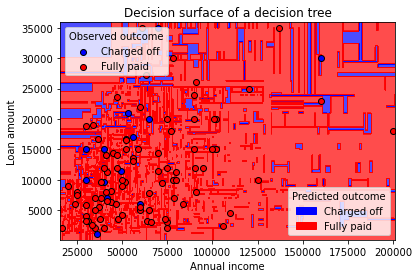

In [ ]:
n_classes = 2
plot_colors = 'br'

labels = ['Charged off', 'Fully paid']

clf = DecisionTreeClassifier().fit(df[['annual_inc', 'loan_amnt']], df['loan_status'].cat.codes)

# Plot the decision boundary

plot_step = 100
viridis = cm.get_cmap('viridis', 2)
newcolors = viridis(np.linspace(0, 1, 2))
blue = np.array([0, 0, 1, 1])
red = np.array([1, 0, 0, 1])
newcolors[0, :] = blue
newcolors[1, :] = red
newcmp = ListedColormap(newcolors)

np.random.seed(0)
idx_plot = np.random.choice(df.shape[0], 100, replace = False )
df_plot = df.iloc[idx_plot]

x_min, x_max = df_plot['annual_inc'].min() - 1000, df_plot['annual_inc'].max() + 1000
y_min, y_max = df_plot['loan_amnt'].min() - 1000, df_plot['loan_amnt'].max() + 1000
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

fig, ax = plt.subplots()
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=newcmp, alpha = 0.7)

plt.xlabel('Annual income')
plt.ylabel('Loan amount')
plt.axis('tight');

for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(df_plot['loan_status'].cat.codes == i)
    plt.scatter(df_plot.iloc[idx]['annual_inc'], df_plot.iloc[idx]['loan_amnt'], c=color, 
                label=labels[i], edgecolors='black')

legend_elements = [Patch(facecolor='blue', edgecolor='blue', label='Charged off'),
                   Patch(facecolor='red', edgecolor='red', label='Fully paid')]

plt.axis('tight')
plt.title('Decision surface of a decision tree')
leg1 = ax.legend(loc='upper left', title='Observed outcome')
ax.legend(handles=legend_elements, loc='lower right', title='Predicted outcome');
ax.add_artist(leg1);

### Random forest para mejorar el rendimiento del árbol de decisión

**Los bosques aleatorios** podrían ser el algoritmo de aprendizaje automático más popular tanto para la clasificación como para la regresión. La idea detrás de los bosques aleatorios es construir un montón de árboles de decisión y, a continuación, utilizar un mecanismo de votación para producir una predicción final que sea acordada por la mayoría de los árboles de decisión. Al entrenar estos árboles individuales, también submuestreamos el conjunto de datos, así como las covariables disponibles, para obtener la mayor validación cruzada posible. Como resultado, el problema del sobreajuste y la estabilidad en un único modelo de árbol de decisión se resuelve en gran medida. Vamos a ajustar un clasificador de bosque aleatorio con las covariables `term` y `annual_inc` y a generar su curva ROC utilizando los datos de entrenamiento:

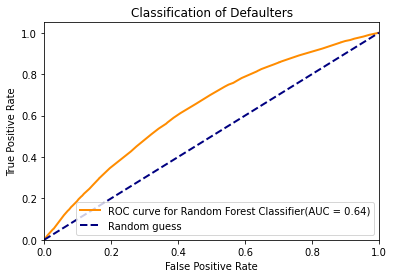

In [ ]:
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf_rf.fit(df_log[['annual_inc', 'term']], df['loan_status'].cat.codes)
clf_rf_probas = clf_rf.predict_proba(df_log[['annual_inc', 'term']])

roc_p = roc_curve(df['loan_status'].cat.codes, clf_rf_probas[:,1])
auc_p = auc_p = auc( roc_p[0], roc_p[1] )

plt.figure()
line_width = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange', lw=line_width,
         label=f"ROC curve for Random Forest Classifier(AUC = {auc_p:0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc='lower right')
plt.show()